# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\ahmad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [10]:
import ast, os, cv2
import pandas as pd
import numpy as np
from mrcnn import utils

_MODEL = "RCNN"
_WORKPATH = r'C:\Users\ahmad\Kaggle\data-science-bowl-2018'
_TRAINCSV = os.path.join(_WORKPATH, 'Train.csv')
_TESTCSV = os.path.join(_WORKPATH, _MODEL+'Test.csv')

cv2.setUseOptimized(True)


class NucleiDataset(utils.Dataset):

    def loadimg(self, path, color=cv2.IMREAD_COLOR, size=None):
        img = cv2.imread(path, color)
        if size:
            img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        return img

    def load_nuclei(self, count, height, width, aug=False):

        self.add_class("shapes", 1, "nuclei")
        traindf = pd.read_csv(_TRAINCSV)

        for i in range(len(traindf['img_id'])):
            self.add_image("shapes", image_id=str(i), path=traindf['image_path'].loc[i], width=width, height=height,
                           maskpath=traindf['mask_dir'].loc[i])
            if 'augs_path' in traindf.columns and aug:
                for j, augpath in enumerate(ast.literal_eval(traindf['augs_path'].loc[i])):
                    self.add_image("shapes", image_id=str(i) + "_" + str(j), path=augpath, width=width, height=height,
                                   maskpath=ast.literal_eval(traindf['augs_path'].loc[i])[j])

    def image_reference(self, image_id):

        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return "nuclei"
        else:
            super(self.__class__).image_reference(image_id)

    def load_mask(self, image_id, size=None):

        class_ids = []
        info = self.image_info[image_id]
        rawmask = info['maskpath']
        count = len(rawmask) if ".png" in rawmask else len(os.listdir(rawmask))
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        if ".png" in rawmask:
            _masktmp = self.loadimg(rawmask, cv2.IMREAD_COLOR, size=(info['height'], info['width']))
            mask = _masktmp[:, :, np.newaxis]
        else:
            for i, path in enumerate(next(os.walk(rawmask))[2]):
                _maskpath = os.path.join(rawmask, path)
                _masktmp = self.loadimg(_maskpath, cv2.IMREAD_GRAYSCALE, size=(info['height'], info['width']))
                mask[:, :, i:i + 1] = _masktmp[:, :, np.newaxis]

        for i in range(count):
            class_ids.append(1)
        class_ids = np.array(class_ids)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

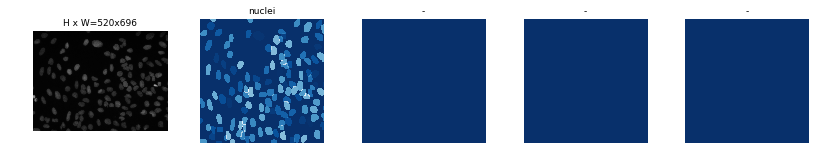

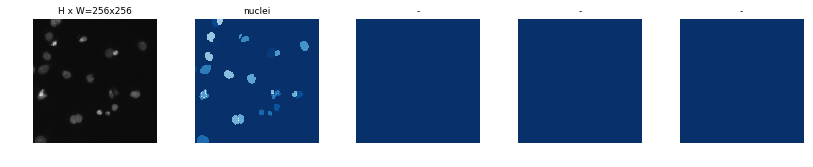

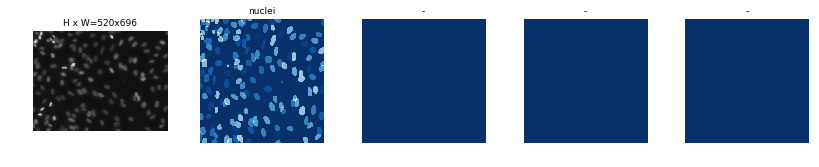

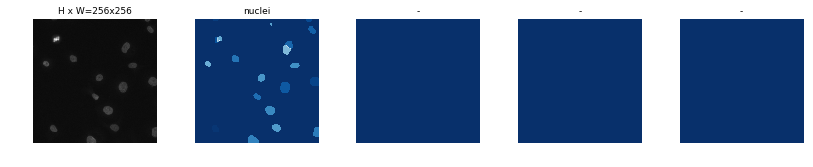

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\ahmad\Kaggle\data-science-bowl-2018\Mask_RCNN\logs\shapes20180408T1940\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

C:\Users\ahmad\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 191s 2s/step - loss: 3.2847 - rpn_class_loss: 0.2967 - rpn_bbox_loss: 1.4724 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.7339 - mrcnn_mask_loss: 0.5748 - val_loss: 2.8506 - val_rpn_class_loss: 0.1662 - val_rpn_bbox_loss: 1.2002 - val_mrcnn_class_loss: 0.2539 - val_mrcnn_bbox_loss: 0.6733 - val_mrcnn_mask_loss: 0.5570


In [16]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\ahmad\Kaggle\data-science-bowl-2018\Mask_RCNN\logs\shapes20180408T1940\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

C:\Users\ahmad\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/100
100/100 [==============================] - 213s 2s/step - loss: 2.6922 - rpn_class_loss: 0.1575 - rpn_bbox_loss: 1.1899 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.5548 - val_loss: 2.5881 - val_rpn_class_loss: 0.1489 - val_rpn_bbox_loss: 1.0484 - val_mrcnn_class_loss: 0.2280 - val_mrcnn_bbox_loss: 0.6067 - val_mrcnn_mask_loss: 0.5561
Epoch 3/100
100/100 [==============================] - 202s 2s/step - loss: 2.5830 - rpn_class_loss: 0.1490 - rpn_bbox_loss: 1.1228 - mrcnn_class_loss: 0.1825 - mrcnn_bbox_loss: 0.5759 - mrcnn_mask_loss: 0.5529 - val_loss: 2.6184 - val_rpn_class_loss: 0.1575 - val_rpn_bbox_loss: 1.1743 - val_mrcnn_class_loss: 0.2120 - val_mrcnn_bbox_loss: 0.5386 - val_mrcnn_mask_loss: 0.5360
Epoch 4/100
100/100 [==============================] - 203s 2s/step - loss: 2.5377 - rpn_class_loss: 0.1426 - rpn_bbox_loss: 1.0847 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.5745 - mrcnn_mask_loss: 0.5518 - val_loss: 2.5002 - val_rpn_clas

Epoch 24/100
100/100 [==============================] - 197s 2s/step - loss: 2.2469 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.9472 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.5370 - val_loss: 2.3102 - val_rpn_class_loss: 0.1082 - val_rpn_bbox_loss: 0.9215 - val_mrcnn_class_loss: 0.2019 - val_mrcnn_bbox_loss: 0.5182 - val_mrcnn_mask_loss: 0.5603
Epoch 25/100
100/100 [==============================] - 201s 2s/step - loss: 2.2524 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.9483 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.5409 - val_loss: 2.2197 - val_rpn_class_loss: 0.1031 - val_rpn_bbox_loss: 0.9216 - val_mrcnn_class_loss: 0.1749 - val_mrcnn_bbox_loss: 0.4899 - val_mrcnn_mask_loss: 0.5302
Epoch 26/100
100/100 [==============================] - 193s 2s/step - loss: 2.2453 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 0.9502 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.5363 - val_loss: 2.2246 - val_rpn_c

Epoch 46/100
100/100 [==============================] - 198s 2s/step - loss: 2.1579 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.9169 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.5297 - val_loss: 2.1579 - val_rpn_class_loss: 0.1038 - val_rpn_bbox_loss: 0.9179 - val_mrcnn_class_loss: 0.1789 - val_mrcnn_bbox_loss: 0.4261 - val_mrcnn_mask_loss: 0.5312
Epoch 47/100
100/100 [==============================] - 198s 2s/step - loss: 2.1173 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 0.9017 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.5266 - val_loss: 2.1428 - val_rpn_class_loss: 0.0997 - val_rpn_bbox_loss: 0.8970 - val_mrcnn_class_loss: 0.1848 - val_mrcnn_bbox_loss: 0.4337 - val_mrcnn_mask_loss: 0.5276
Epoch 48/100
100/100 [==============================] - 193s 2s/step - loss: 2.1259 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.9062 - mrcnn_class_loss: 0.1759 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.5257 - val_loss: 2.1011 - val_rpn_c

Epoch 68/100
100/100 [==============================] - 197s 2s/step - loss: 2.0544 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 0.8833 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.5206 - val_loss: 1.9856 - val_rpn_class_loss: 0.0935 - val_rpn_bbox_loss: 0.8418 - val_mrcnn_class_loss: 0.1789 - val_mrcnn_bbox_loss: 0.3676 - val_mrcnn_mask_loss: 0.5039
Epoch 69/100
100/100 [==============================] - 193s 2s/step - loss: 2.0411 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 0.8839 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.5183 - val_loss: 2.0573 - val_rpn_class_loss: 0.1076 - val_rpn_bbox_loss: 0.8947 - val_mrcnn_class_loss: 0.1748 - val_mrcnn_bbox_loss: 0.3686 - val_mrcnn_mask_loss: 0.5116
Epoch 70/100
100/100 [==============================] - 197s 2s/step - loss: 2.0512 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.8763 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.5191 - val_loss: 2.0482 - val_rpn_c

Epoch 90/100
100/100 [==============================] - 194s 2s/step - loss: 1.9876 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.8570 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.3501 - mrcnn_mask_loss: 0.5117 - val_loss: 2.0201 - val_rpn_class_loss: 0.0896 - val_rpn_bbox_loss: 0.8663 - val_mrcnn_class_loss: 0.1674 - val_mrcnn_bbox_loss: 0.3649 - val_mrcnn_mask_loss: 0.5319
Epoch 91/100
100/100 [==============================] - 197s 2s/step - loss: 1.9826 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 0.8682 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.5095 - val_loss: 1.9666 - val_rpn_class_loss: 0.0894 - val_rpn_bbox_loss: 0.8697 - val_mrcnn_class_loss: 0.1756 - val_mrcnn_bbox_loss: 0.3305 - val_mrcnn_mask_loss: 0.5015
Epoch 92/100
100/100 [==============================] - 196s 2s/step - loss: 1.9725 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.8566 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.5113 - val_loss: 1.9645 - val_rpn_c

In [21]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_128r100e8b.h5")
model.keras_model.save_weights(model_path)

## Detection

In [27]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=model_path)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]
model_path = os.path.join(MODEL_DIR, "mask_rcnn_128r100e8b.h5")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Loading weights from  C:\Users\ahmad\Kaggle\data-science-bowl-2018\Mask_RCNN\logs\mask_rcnn_128r100e8b.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  214.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  647.00000  float64
gt_class_id              shape: (26,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (26, 4)               min:    0.00000  max:   64.00000  int32
gt_mask                  shape: (77, 51, 26)          min:    0.00000  max:    1.00000  bool


ValueError: operands could not be broadcast together with shapes (77,51) (128,128) (128,128) 

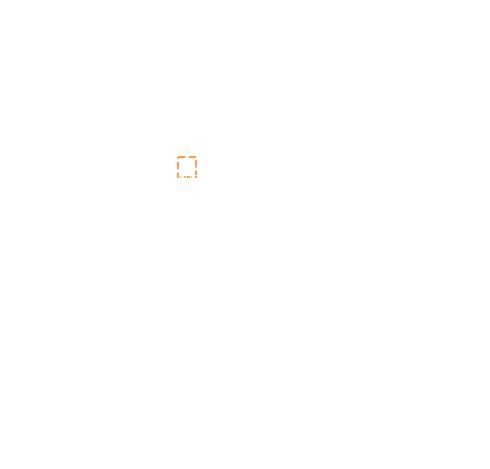

In [33]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


#plt.imsave(fname= r"C:\Users\ahmad\Kaggle\data-science-bowl-2018\Mask_RCNN\samples\nuclei\ori.png", arr = original_image)
#plt.imsave(fname= r"C:\Users\ahmad\Kaggle\data-science-bowl-2018\Mask_RCNN\samples\nuclei\meta.png", arr = gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))